In [1]:
import argparse
import pickle
import random

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument("--random_seed", type=int, default=12345, help="Random seed.")

parser.add_argument("--evidence_filepath", type=str, default="./data/arts_top-100-concepts_evidence.pkl", help="Path to the observed evidence.")

parser.add_argument("--prior_model_path", type=str, default="./models/rc_arts_num-head-concepts-100.pkl", help="Path to a machine learning model that gives prior probabilities.")

parser.add_argument("--sample_size", type=int, default=1000, help="Number of samples to draw from each chain of the posterior.")

parser.add_argument("--num_chains", type=int, default=4, help="Number of chains in the sampler.")

# workaround to use argparse in jupyter notebook
# https://stackoverflow.com/questions/50763033/argparse-in-jupyter-notebook-throws-a-typeerror
args = parser.parse_args([])
random.seed(args.random_seed)

In [3]:
with open(args.evidence_filepath, "rb") as f:
    evidence = pickle.load(f)
    print("Number of relation variables:", len(evidence))
    
e1_values = []
e2_values = []
for e in evidence:
    e1_values.append(e[1][0])
    e2_values.append(e[1][1])
e1_values = np.array(e1_values)
e2_values = np.array(e2_values)
# x_values = np.column_stack((e1_values, e2_values))

with open(args.prior_model_path, "rb") as f:
    prior_model = pickle.load(f)

Number of relation variables: 9900


In [4]:
with pm.Model() as model:
    e1 = pm.Normal("e1", mu=0, sigma=1, shape=len(evidence), observed=e1_values)
    e2 = pm.Normal("e2", mu=0, sigma=1, shape=len(evidence),observed=e2_values)

    ml_prior = prior_model.predict_proba(np.column_stack((e1.eval(), e2.eval())))[:, 1]

    r = pm.Bernoulli("r", p=ml_prior, shape=len(evidence))

    # Use the Metropolis-Hastings sampler
    # step = pm.Metropolis()
    # step = pm.BinaryMetropolis([r])
    step = pm.BinaryGibbsMetropolis([r])

    # Run the sampler
    trace = pm.sample(args.sample_size, step=step, chains=args.num_chains, random_seed=args.random_seed)

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [r]


In [9]:
print(ml_prior)

[0.53299414 0.84218822 0.02926784 ... 0.50218808 0.51580493 0.24338816]


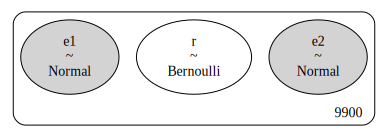

In [8]:
pm.model_to_graphviz(model)

In [6]:
pm.summary(trace, round_to=2)

/home/congtj/miniconda3/envs/openforge-pymc/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r[0],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
r[1],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
r[2],0.0,0.0,0.0,0.0,0.0,0.0,4000.0,4000.0,NaN
r[3],0.0,0.0,0.0,0.0,0.0,0.0,4000.0,4000.0,NaN
r[4],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
r[9895],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
r[9896],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
r[9897],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
r[9898],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN


array([[<Axes: title={'center': 'r'}>, <Axes: title={'center': 'r'}>]],
      dtype=object)

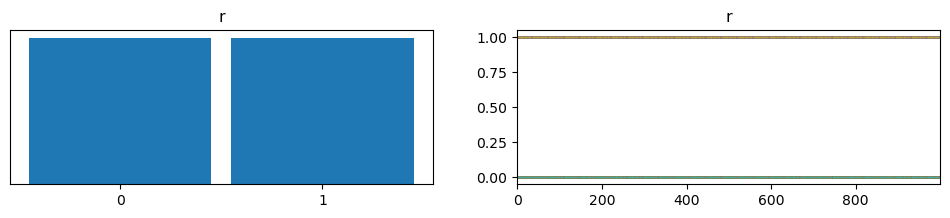

In [7]:
az.plot_trace(trace, combined=True)

In [15]:
print(trace.posterior.r.values.shape)
print(trace.posterior.r.values[0])

(4, 1000, 9900)
[[1 1 0 ... 1 1 0]
 [1 1 0 ... 1 1 0]
 [1 1 0 ... 1 1 0]
 ...
 [1 1 0 ... 1 1 0]
 [1 1 0 ... 1 1 0]
 [1 1 0 ... 1 1 0]]


In [17]:
sample_counts = {}

for sample in trace.posterior.r.values[0]:
    sample_str = "".join([str(int(s)) for s in sample])
    if sample_str not in sample_counts:
        sample_counts[sample_str] = 1
    else:
        sample_counts[sample_str] += 1

In [18]:
print(sample_counts)

{'11001000100001011001111111000010101010011010101011010011001100100000000100110000001110010101000000111001010010101001101010000111000101100000100010100011110110011010001010110010101010001101011111100001010000001101001011101101010110010000101110001111111001110000100011110100011011101111101110010010111001011100110011110100011010000000100101100001010100100010001101000011111001010010100111100101000001010001000000001000010011101010100111011001111111010010110010101011101000010011100101010100000100001000010010001100101000001010011101000111110010010000001001100001100010101110000111110101111000011010001001001101100000000111000111110111011110101101011001100001010101111000110100111100010001011000110110100000000111001001001111100010001110001101010101111101110100100101001100011001011001100101000101111110100100011100011011011110100100011000101010111101111000111000001010110100101010010101111110101001101001010111001011001111001101000011110000100000100011001100000110100001111101011001111011111110101010